This task is evaluated with a precision of 1 (values rounded to full numbers).

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from baseline import print_rules
from tasks.running_example import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

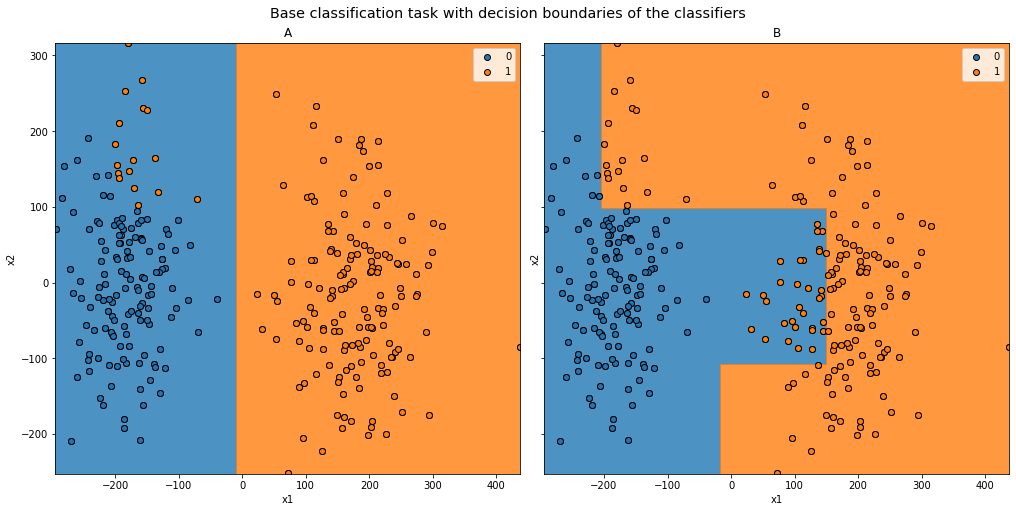

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

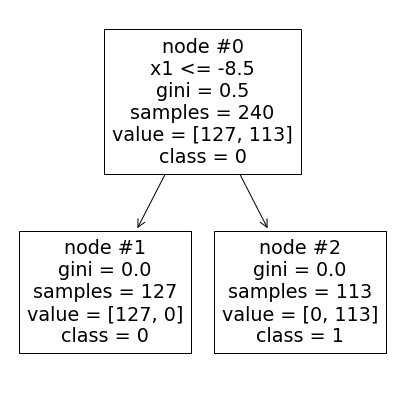

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_tree(comparer.clf_a, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=1);

Classifier A is a decision tree with just one node. It can be described with one simple rule.

In [9]:
print_rules(comparer.clf_a, comparer.feature_names, comparer.base_class_names, '1')

node #2: if (x1 > -9.0) then class 1 (covers 1.0 of 113 instances)
coverage (train set): 1.0


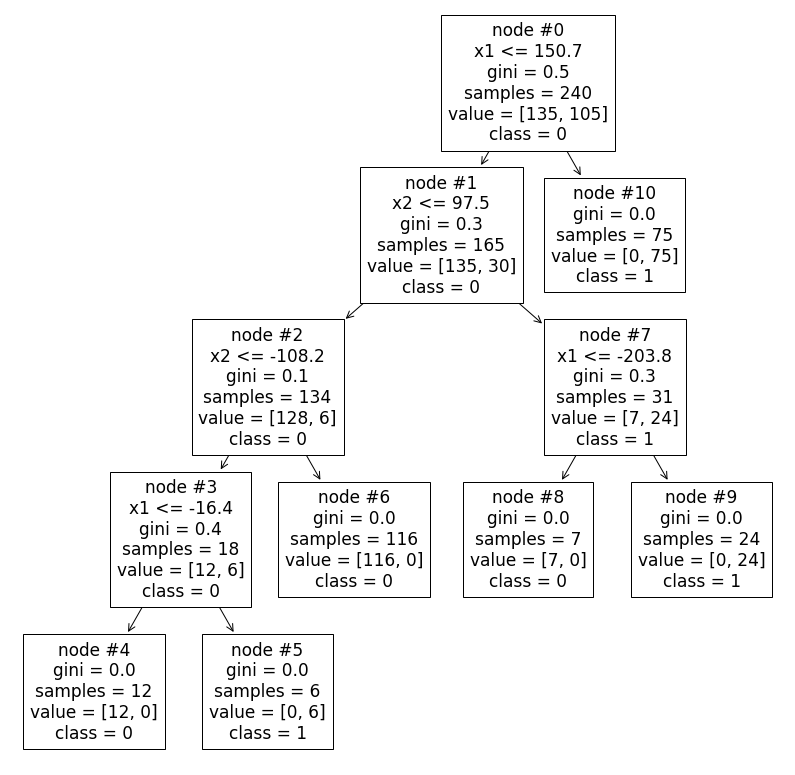

In [10]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_tree(comparer.clf_b, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=1);

Whereas model B needs three rules:

In [12]:
print_rules(comparer.clf_b, comparer.feature_names, comparer.base_class_names, '1')

node #10: if (x1 > 150.0) then class 1 (covers 1.0 of 75 instances)
node #9: if (x1 > -204.0) and (x1 <= 150.0) and (x2 > 97.0) then class 1 (covers 1.0 of 24 instances)
node #5: if (x1 > -17.0) and (x1 <= 150.0) and (x2 <= -109.0) then class 1 (covers 1.0 of 6 instances)
coverage (train set): 1.0


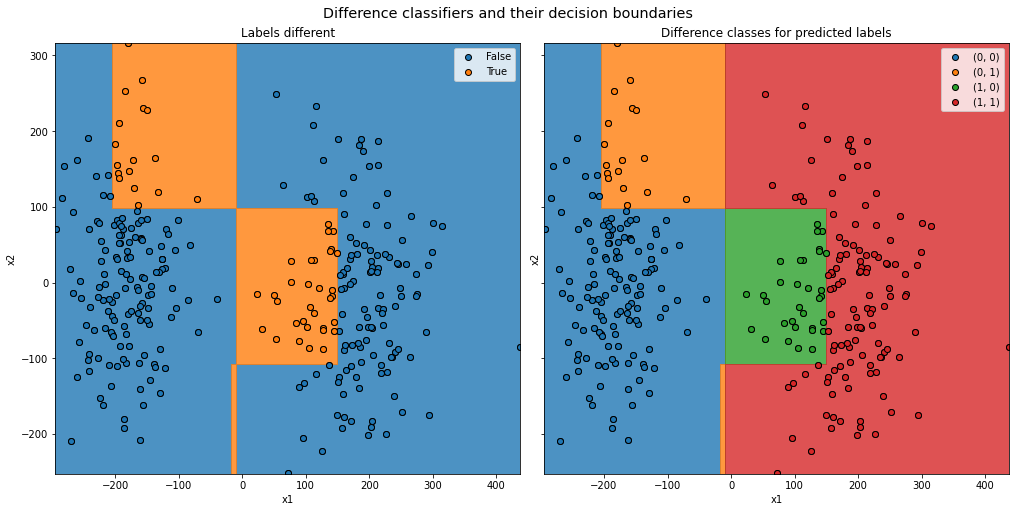

In [13]:
comparer.plot_decision_boundaries(X)

The differences can be represented by a rule set too:
1. $-204<x1≤-9, x2>97 \rightarrow (0,1)$
2. $-9<x1≤150, -109<x2≤97 \rightarrow (1,0)$
3. $-17<x1≤-9, x2≤-109 \rightarrow (0,1)$

This can be considered the minimal set of rules that describes the differences.

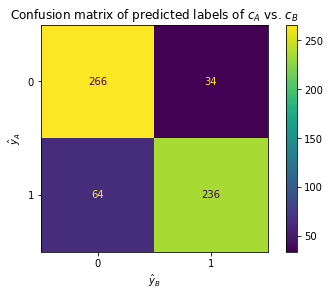

In [10]:
comparer.plot_confusion_matrix(X)